In [217]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import pickle
import torch
from torch import nn
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
import os
import sys

current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from dataHandler.preprocessor import Preprocessor
from sklearn import model_selection


print(torch.__version__)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

2.3.0+cu121
Using cpu device


__Getting data__

In [218]:
directory = "/home/michal/Desktop/UniversityOfEssex/MasterProject/22-24_CE901-CE911-CF981-SU_kaczmarczyk_michal_p/data/Bloomberg/"
files = os.listdir(directory)
files = [f for f in files if os.path.isfile(directory+'/'+f)]
files
files = ["RR.L.csv"]

In [219]:
dataDir = "/home/michal/Desktop/UniversityOfEssex/MasterProject/22-24_CE901-CE911-CF981-SU_kaczmarczyk_michal_p/data/data/"
dataset = []
for file in files:
    df = pd.read_csv(dataDir + file).set_index("Date")
    df.index = pd.to_datetime(df.index)
    bl = pd.read_csv(directory + file).set_index("Date")
    bl.index = pd.to_datetime(bl.index)
    bl = bl["Price Earnings Ratio \n(P/E) \n(RR/ LN Equity)"]
    bl = bl.resample('D')
    bl = bl.ffill()
    bl = bl.bfill()
    df = df.join(bl, how="inner")
    dataset.append(df)

__Spliting Data__

In [220]:
trainDataset = []
testDataset = []
preprocessor = Preprocessor()
i=0
for df in dataset:
    df.insert(0, "Date", df.index)
    df = preprocessor.leaveDataSinceDate(df)
    #if files[i] == "RR.L.csv":
    train, test = model_selection.train_test_split(df, test_size=0.2, shuffle=False)
    trainDataset.append(train)
    testDataset.append(test)
    #else:
    #    trainDataset.append(df)
    i+=1

__Preprocessing__

In [221]:
preprocessor = Preprocessor()
for i in range(len(trainDataset)):
    trainDataset[i] = preprocessor.dropUnnamedColumn(trainDataset[i])
    trainDataset[i] = preprocessor.dropDuplicates(trainDataset[i])
    trainDataset[i] = preprocessor.addChangeFeature(trainDataset[i])
    columns = trainDataset[i].columns
    trainDataset[i][columns[1:]] = preprocessor.fillMissingData(trainDataset[i][columns[1:]])
    trainDataset[i][columns[1:]] = preprocessor.scaleData(trainDataset[i][columns[1:]])
    trainDataset[i] = preprocessor.sortValuesByDate(trainDataset[i])
    trainDataset[i].set_index("Date", inplace = True)

In [222]:
preprocessor = Preprocessor()
for i in range(len(testDataset)):
    testDataset[i] = preprocessor.dropUnnamedColumn(testDataset[i])
    testDataset[i] = preprocessor.dropDuplicates(testDataset[i])
    testDataset[i] = preprocessor.addChangeFeature(testDataset[i])
    columns = testDataset[i].columns
    testDataset[i][columns[1:]] = preprocessor.fillMissingData(testDataset[i][columns[1:]])
    testDataset[i][columns[1:]] = preprocessor.scaleData(testDataset[i][columns[1:]])
    testDataset[i] = preprocessor.sortValuesByDate(testDataset[i])
    testDataset[i].set_index("Date", inplace = True)

preprocessor.saveScalers()

__Date Embedding and cyclical transformation__

In [223]:

def getDateRange(start_date, end_date):
    current_date = start_date
    dates = []
    while current_date <= end_date:
        dates.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=1)
    return dates

# Define the date range
start_date = datetime(2024, 5, 24) - timedelta(days=40*365)  # 40 years ago
end_date = datetime(2024, 5, 24) + timedelta(days=40*365)    # 40 years in the future

# Generate the list of dates
dictionary = getDateRange(start_date, end_date)
date_to_index = {date: index for index, date in enumerate(dictionary)}

class DateEmbeddingModel(nn.Module):
    def __init__(self, num_embeddings = 29201, embedding_dim = 8):
        super(DateEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, dates):
        date_indices = torch.tensor([date_to_index[date] for date in dates], dtype=torch.long)
        embedded_dates = self.embedding(date_indices)
        return embedded_dates

In [224]:
def dateCyclicalTransformation(date):
    date = pd.to_datetime(date)

    monthSin = np.sin(2 * np.pi * date.month/12.0)
    monthCos = np.cos(2 * np.pi * date.month/12.0)
    daySin = np.sin(2 * np.pi * date.day/31.0)
    dayCos = np.cos(2 * np.pi * date.day/31.0)

    return [monthSin, monthCos, daySin, dayCos]

In [225]:
'''date = train.index.map(dateCyclicalTransformation)
date = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(train.index)
train = train.join(date)

date = validation.index.map(dateCyclicalTransformation)
date = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(validation.index)
validation = validation.join(date)

date = test.index.map(dateCyclicalTransformation)
date = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(test.index)
test = test.join(date)'''

'date = train.index.map(dateCyclicalTransformation)\ndate = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(train.index)\ntrain = train.join(date)\n\ndate = validation.index.map(dateCyclicalTransformation)\ndate = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(validation.index)\nvalidation = validation.join(date)\n\ndate = test.index.map(dateCyclicalTransformation)\ndate = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(test.index)\ntest = test.join(date)'

__Creating data loader for trend__

In [226]:
def createSequenceForTrend(dataX, dataY, lengthX, predictionHorizont):
    xData = []
    yData = []
    for i in range(len(dataX) - lengthX - predictionHorizont):
        xData.append(dataX[i:i+lengthX].values)

        if(dataY[lengthX+i - 1] <= dataY[lengthX + predictionHorizont + i - 1]):
            yData.append(1.0)
        else:
            yData.append(0.0)
    return xData, yData

features = len(trainDataset[0].iloc[0])
samplesForPrediction = 5
samplesPredicted = 1

trainDates = trainDataset[0].index[samplesForPrediction+1:]
testDates = testDataset[0].index[samplesForPrediction+1:]
xTrain = []
yTrain = []
xTest = []
yTest = []
for df in trainDataset:
    trainX, trainY = createSequenceForTrend(df, df["Close"], samplesForPrediction, samplesPredicted)
    xTrain += trainX
    yTrain += trainY
for df in testDataset:
    testX, testY = createSequenceForTrend(df, df["Close"], samplesForPrediction, samplesPredicted)
    xTest += testX
    yTest += testY

/tmp/ipykernel_6783/390145126.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(dataY[lengthX+i - 1] <= dataY[lengthX + predictionHorizont + i - 1]):


__Model__

In [227]:
xTrain = np.array(xTrain)
yTrain = np.array(yTrain)
xTest = np.array(xTest)
yTest = np.array(yTest)

num_samples, num_days, num_features = xTrain.shape
xTrain_flattened = xTrain.reshape(num_samples, num_days * num_features)

num_samples, num_days, num_features = xTest.shape
xTest_flattened = xTest.reshape(num_samples, num_days * num_features)

In [228]:
svr = SVC(kernel='rbf', degree=5, C=600000.0, max_iter=-1, tol = 1e-2)
svr.fit(xTrain_flattened, yTrain)
#pickle.dump(svr, open("../models/svr_params.pickle", "wb"))

# Load the parameters from file
#svrMultiOutput = pickle.load(open("../models/svr_params.pickle", "rb"))


SVC(C=600000.0, degree=5, tol=0.01)

__Train results__

In [229]:
# Make predictions
y_pred = svr.predict(xTrain_flattened)

# Calculate the mean squared error across all outputs
accuracy_total = accuracy_score(yTrain, y_pred)
print(f'Accuracy: {accuracy_total}')

recall_total = recall_score(yTrain, y_pred)
print(f'Recall: {recall_total}')



Accuracy: 0.8843264897346019
Recall: 0.8844984802431611


__Test results__

In [230]:
# Make predictions
y_pred = svr.predict(xTest_flattened)

# Print the shape of predictions to verify
print(y_pred.shape)  # Should be (num_samples, prediction horizont)

(495,)


In [231]:
# Calculate the mean squared error across all outputs
accuracy_total = accuracy_score(yTest, y_pred)
print(f'Accuracy: {accuracy_total}')

recall_total = recall_score(yTest, y_pred)
print(f'Recall: {recall_total}')

Accuracy: 0.5333333333333333
Recall: 0.7769516728624535


__Profit calculation__

In [232]:
#Rescaling
dummyDataset = testDataset[0]
dummyDataset["Close"] = testDataset[0]['Close']
dummyDataset = preprocessor.scaler.inverse_transform(dummyDataset)
real = dummyDataset[:,3]

In [233]:
#real = np.concatenate(yTrain.cpu().detach().numpy()[::1])
profit = 0
lastBuy = 0
action = []

#real = testDataset[0]['Close'].values

for realVal, predVal in zip(real[samplesForPrediction::samplesPredicted], y_pred[samplesPredicted::samplesPredicted]):
    if(predVal==1 and lastBuy == 0):
        lastBuy = realVal
        action.append(1)
    elif(predVal==0 and lastBuy > 0):
        profit += realVal - lastBuy
        lastBuy = 0
        action.append(-1)
    else:
        action.append(0)

if(lastBuy>0):
    profit += realVal - lastBuy
    lastBuy = 0
    action.append(-1)
else:
    action.append(0)

print(profit)

234.3099529999999


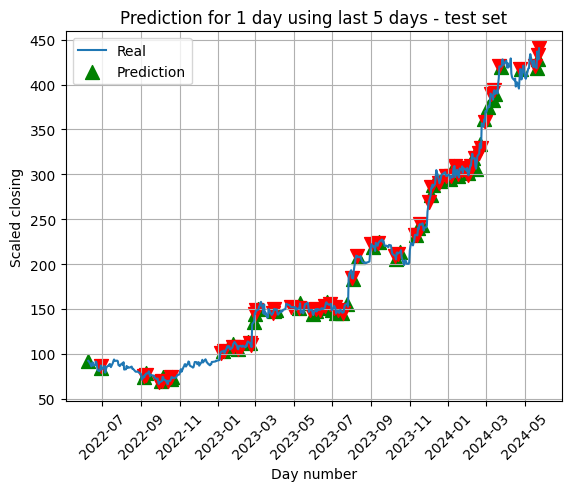

In [234]:
real2 = real[samplesForPrediction:-1]
testDatesP = testDates[:]
action = np.array(action[:])

buy_dates = np.array(testDatesP)[action == 1]
sell_dates = np.array(testDatesP)[action == -1]

buy_prices = real2[action == 1]
sell_prices = real2[action == -1]

fig, ax = plt.subplots()
ax.plot(np.array(testDatesP), real2, zorder = 3)

ax.scatter(buy_dates, buy_prices, color='green', marker='^', s=100, label='Buy')
ax.scatter(sell_dates, sell_prices, color='red', marker='v', s=100, label='Sell')

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Optionally, set the locator to have fewer ticks
locator = plt.matplotlib.dates.AutoDateLocator(minticks=10, maxticks=20)
ax.xaxis.set_major_locator(locator)

ax.legend(["Real", "Prediction"])
ax.grid()
plt.ylabel("Scaled closing")
plt.xlabel("Day number")
plt.title("Prediction for 1 day using last 5 days - test set")
plt.show()

